<a href="https://colab.research.google.com/github/IoPapadopoulos/ttbar_analysis/blob/main/ttbar_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**How to Rediscover the Top-Antitop $t\bar{t}$ Quark Pair Production Yourself!**

This notebook uses ATLAS Open Data to guide you through the steps needed to rediscover the production of top-antitop quark pairs $t\bar{t}$ in high-energy proton-proton collisions at the Large Hadron Collider (LHC).

ATLAS Open Data provides open access to proton-proton collision data collected by the ATLAS experiment at the LHC. These datasets are made available for educational purposes, making them ideal for high-school, undergraduate, and postgraduate students interested in learning about particle physics.

# **What Are Notebooks?**

Notebooks are interactive web applications that allow you to create and share documents that contain:

1. **Live code:** Write and execute code in real-time, making adjustments as you go.

2. **Visualizations:** Create plots, histograms, and other graphical representations of your data to better understand the underlying physics.

3. **Narrative text:** Include explanations, descriptions, and commentary to guide yourself or others through the analysis.


# **The Goal: Rediscovering $t\bar{t}$ Production**

By following this notebook, you will perform a $t\bar{t}$ analysis, aiming to identify and study the production of top-antitop quark pairs. The process involves applying a series of selection cuts and analysis techniques to increase the ratio of signal (events where $t\bar{t}$ pairs are produced) to background (other processes that can mimic the signal).

A key part of this analysis is focusing on the semileptonic decay of the $t\bar{t}$ pair. In this decay mode, one top quark decays into a W boson and a b-quark, with the W boson further decaying into a charged lepton and a neutrino, while the other top quark decays hadronically (into jets).This can be represented as:
* $ t\bar{t} \rightarrow lvb\bar{b}q\bar{q}$

where:

* $l$ is a lepton,
* $v$ is a neutrino,
* $b$ is a b-tagged jet,
* $q$ is a jet.


**Contents:**
* Running a Jupyter notebook
* To setup
* Explanation of Key Parameters in the $t\bar{t}$ Analysis Code
* Samples
* Weight in Particle Physics Analysis
* Introduction to Event Selection Cuts in $t\bar{t}$ Analysis
* Introduction to Mass Reconstruction in $t\bar{t}$ Analysis
* Data Processing and Event Selection Function
* Data Retrieval in $t\bar{t}$ Analysis
* Data Processing
* Data Aggregation with Loops
* Combining Mass and Weight Lists
* Plotting


# **Running a Jupyter notebook**
To run the whole Jupyter notebook, in the top menu click Cell -> Run All.

To propagate a change you've made to a piece of code, click Cell -> Run All Below.

You can also run a single code cell, by clicking Cell -> Run Cells, or using the keyboard shortcut Shift+Enter.


# **ATLAS Open Data Initialisation**
**First time package installation on your computer**

This first cell installs the required python packages. It only needs to be run the first time you open this notebook on your computer. If you close Jupyter and re-open on the same computer, you won't need to run this first cell again.

In [1]:
#install required packages
import sys
!pip install atlasopenmagic
from atlasopenmagic import install_from_environment
install_from_environment()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.5/253.5 kB 4.6 MB/s eta 0:00:00
Installing packages: ['aiohttp>=3.9.5', 'atlasopenmagic', 'awkward>=2.6.7', 'awkward-pandas>=2023.8.0', 'coffea~=0.7.0', 'hist>=2.8.0', 'ipykernel>=6.29.5', 'jupyter>=1.0.0', 'lmfit>=1.3.2', 'matplotlib>=3.9.1', 'metakernel>=0.30.2', 'notebook<7', 'numpy>=1.26.4', 'pandas>=2.2.2', 'papermill>=2.6.0', 'pip>=24.2', 'scikit-learn>=1.5.1', 'uproot>=5.3.10', 'uproot3>=3.14.4', 'fsspec-xrootd>=0.5.1', 'jupyterlab_latex~=3.1.0', 'vector>=1.4.1']
Installation complete. You may need to restart your Python environment for changes to take effect.


# **To setup**
Cell -> Run All Below

to be done every time you re-open this notebook

We're going to be using a number of tools to help us:

* uproot: lets us read .root files typically used in particle physics into data formats used in python
* awkward: lets us use efficiently the nested data in columnar format
* pandas: lets us store data as dataframes, a format widely used in python
* numpy: provides numerical calculations such as histogramming
* matplotlib: common tool for making plots, figures, images, visualisations
* concurrent.futures: Enables parallel execution, which speeds up computations when working with large datasets.

In [2]:
import uproot  # For reading ROOT files efficiently
import awkward as ak  # To represent nested data in columnar format
import numpy as np  # For numerical calculations such as histogramming
import pandas as pd # For dataframes, a format widely used in python
import matplotlib.pyplot as plt  # For creating plots and visualizations
from matplotlib.ticker import AutoMinorLocator  # For adding minor ticks to plot axes
import atlasopenmagic as atom  # Provides access to ATLAS Open Data metadata and streaming URLs
from concurrent.futures import ProcessPoolExecutor, as_completed # Enables parallel execution for faster processing of large datasets

import time  # For timing operations and adding delays if needed
# Filter warnings that otherwise appear in output. These are normal in the running of this notebook.
import warnings

warnings.filterwarnings("ignore", message="invalid value encountered in sqrt")
warnings.filterwarnings("ignore", message="overflow encountered in power")
warnings.filterwarnings("ignore", message="overflow encountered in multiply", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="invalid value encountered in subtract")

# **Explanation of Key Parameters in the $t\bar{t}$ Analysis Code**

In particle physics analyses, various parameters and constants are essential for accurately processing data and interpreting results. Below is an explanation of the key parameters used in the
 $t\bar{t}$ analysis code provided:

1.   **Integrated Luminosity (lumi)**

  *   Definition: Integrated luminosity is a measure of the total amount of data collected by a particle detector over a certain period. It represents the total number of potential collisions that could have occurred in a particle accelerator and is typically measured in inverse femtobarns fb$^{-1}$.

2. **Fraction of Events to Process**

  *   Definition: This parameter controls what fraction of the available events in the dataset will be processed by the analysis.


3. **MV2c10 b-Tagging Algorithm Discriminant Cut Value Definition**
  * The MV2c10 is a b-tagging algorithm used to identify jets originating from b-quarks. The discriminant cut value determines the threshold for tagging a jet as a b-jet.

  For further information visit [atlas glossary](https://atlas.cern/glossary)





In [3]:
# Integrated luminosity in inverse picobarns
lumi = 36000.

# Fraction of events to process
fraction = 0.1

# MV2c10 b-tagging algorithm discriminant cut value
MV2c10_lim = 4

# **Samples**
Samples to process

In [4]:
atom.set_release('2025e-13tev-beta')

mc_defs = {
    r'ttbar':    {'dids': [601495,410081,410470]},
    r'single_top': {'dids': [601355,601487,601627,601628,601631,601761,601762,601763,601764]},
    r'diboson':  {'dids': [700488,700489,700490,700491,700492,700493,700495,700496]},
}

mc_samples   = atom.build_mc_dataset(mc_defs, skim='1LMET30', protocol='https')
data_samples_1 = atom.build_data_dataset('1LMET30', name="Data", protocol='https')

samples = {**data_samples_1, **mc_samples}

variables = ["mcWeight", "ScaleFactor_ElTRIGGER", "ScaleFactor_MuTRIGGER", "trigE", "trigM", "lep_n", "lep_pt","ScaleFactor_FTAG","lep_isMediumID",
            "lep_eta", "lep_phi", "lep_charge", "lep_type", "met", "met_phi", "sum_of_weights", "ScaleFactor_FTAG","lep_isLooseIso",
            "xsec", "jet_pt", "jet_btag_quantile", "jet_n", "jet_eta", "jet_phi", "jet_e","jet_jvt","lep_isTrigMatched",
            "lep_type", "lep_e", "eventNumber", "ScaleFactor_ELE", "ScaleFactor_MUON","ScaleFactor_PILEUP","filteff", "kfac"]

# **Weight in Particle Physics Analysis**

In particle physics analysis, such as in the study of the production of top-antitop quark pairs $t\bar{t}$, the concept of "weight" plays a crucial role. Weights are factors applied to events or data points in a dataset to ensure that the results of an analysis accurately reflect the underlying physics being studied. These weights account for various factors, including the efficiencies of detectors, the probability of certain processes occurring, and the corrections needed to match the simulated data with real-world observations.

The following function computes the event weights by combining several correction factors, including trigger efficiencies, pileup corrections, b-tagging efficiencies, and cross-sections. The result is a set of weights that accurately reflect the likelihood and significance of each event, ensuring that the final analysis properly accounts for all relevant physical and experimental considerations.

In [5]:
def calc_weight(data):
    # Calculate the weight
    weight = (data["ScaleFactor_PILEUP"] * data["ScaleFactor_FTAG"] * data["mcWeight"] / 
              data["sum_of_weights"] * lumi * data["xsec"] * data["kfac"] * data["filteff"])
    el_SF = data["ScaleFactor_ELE"] * data["ScaleFactor_ElTRIGGER"] 
    muon_SF = data["ScaleFactor_MUON"] * data["ScaleFactor_MuTRIGGER"] 
    weight = ak.where(ak.firsts(data["lep_type"]) == 11, weight * el_SF, weight * muon_SF) 
    return weight

# **Introduction to Event Selection Cuts in $t\bar{t}$ Analysis**

In particle physics, particularly in the analysis of top-antitop $t\bar{t}$ quark pair production, the process of event selection is crucial for isolating the signal from the background. The goal is to apply a series of cuts, or selection criteria, that filter out events unlikely to be associated with the $t\bar{t}$ process, leaving a dataset enriched with signal events. These cuts are based on specific physical properties of the events, such as the presence and characteristics of leptons, missing transverse energy $E^{miss}_{T}$, and jets.

Each cut is designed to enhance the signal-to-background ratio, which is essential for making a clear observation of the $t\bar{t}$ signal. Below is an overview of the key cuts applied in this analysis:

1. **Trigger Selection:**
  * The first step in the analysis is to ensure that the events under consideration have fired the appropriate triggers.
  * Purpose: This cut checks whether either the electron trigger ('trigE') or the muon trigger ('trigM') has been activated. If either trigger fired, the event is considered for further analysis.

In [6]:
def cut_trig(trigE, trigM):
    # Return True if either electron or muon trigger fired
    return trigE | trigM

  2. **Matched Cut:**

   *    This cut ensures that the event contains one lepton that is matched with a trigger.

   *     Purpose: The cut ensures that one lepton in the event is associated with a trigger, meaning it was responsible for the event being recorded. Applying this cut reduces backgrounds from events where no lepton is properly matched to a trigger, improving the selection efficiency for signal events.

In [7]:
def Matched_cut(Matched):
    return ak.flatten(Matched)

3. **Single Lepton Requirement:**
  * To focus on events characteristic of $t\bar{t}$ decays, we require exactly one lepton (electron or muon) in the event.
  * Purpose: This cut ensures that the event contains precisely one lepton, which is typical in semileptonic $t\bar{t}$ decays where one top quark decays leptonically, and the other decays hadronically.

In [8]:
def one_lep(lep_n):
    # Return True if exactly one lepton in the event
    return lep_n == 1

4. **Lepton Transverse Momentum ($p_𝑇$) Cut:**
  * High transverse momentum leptons are a key feature of $t\bar{t}$ events.
  * Purpose: This cut selects events where the transverse momentum of the lepton is above 30 GeV, ensuring that only significant lepton candidates are considered.

In [9]:
def cut_lep_pt(lep_pt):
    # Return True if lepton pT is above 30 GeV and save a list of the lepton pT in GeV
    return lep_pt >= 30

5. **Missing Transverse Energy ($E^{miss}_{T}$) Cut:**

  * $t\bar{t}$ events often have significant missing transverse energy due to the neutrinos produced in the decay.
  * Purpose: This cut selects events where the missing transverse energy is greater than 30 GeV, helping to reduce background from processes without significant $E^{miss}_{T}$.


In [10]:
def cut_met_et(met):
    # Return True if missing ET is above 30 GeV and save a list of the missing ET in GeV
    return met >= 30

6. **W Boson Transverse Mass  ($M^{W}_{T}$) Cut:**
  * The transverse mass of the W boson, reconstructed from the lepton transverse momentum and $E^{miss}_{T}$.
  * Purpose: This cut ensures that the transverse mass of the W boson is above 30 GeV, further reducing background contamination.

In [11]:
def cut_W_mt(lep_pt, lep_phi, met_et, met_phi):
    # Calculate W transverse mass and apply cut
    Wmt = 2 * lep_pt * met_et * (1 - np.cos(lep_phi - met_phi))
    cut = ak.where(Wmt > 0, np.sqrt(Wmt), 0) >= 30
    return cut

7. **Jet and b-Jet Multiplicity Cuts:**
  * $t\bar{t}$ events typically feature multiple jets, including those tagged as b-jets.
  * Purpose: This cut requires at least four jets, with at least two of them identified as b-jets. This helps isolate the $t\bar{t}$ signal from other processes that produce fewer jets or no b-jets.

In [12]:
def cut_Njet_and_Nbjet(jet_pt, jet_MV2c10):
    # Count jets above pT threshold
    num_pt = ak.sum(jet_pt >= 30, axis=1) >= 4

    # Count b-tagged jets
    num_btag = ak.sum(jet_MV2c10 >= MV2c10_lim, axis=1) >= 2

    # Require at least 4 jets and 2 b-tagged jets
    return (num_pt) & (num_btag)

# **Introduction to Mass Reconstruction in $t\bar{t}$ Analysis**

In the study of top-antitop quark pair production ($t\bar{t}$), accurately reconstructing the masses of the decayed particles is essential for identifying the signal and distinguishing it from background processes. The top quark, the heaviest known elementary particle, typically decays into a W boson and a b-quark. In semileptonic $t\bar{t}$ decays, one W boson decays into a lepton and a neutrino, while the other W boson decays hadronically into jets.

To study these decays, we reconstruct the masses of the hadronically decaying top quark and the semileptonic top quark using the kinematic information of the detected particles. This process involves complex calculations that take into account the momentum, energy, and spatial distributions of the leptons, neutrinos, and jets involved in the decay.

The following function, mtop, performs these calculations, reconstructing the mass of the top quarks in both their hadronic and semileptonic decay channels:

**1. Leptonic Top Quark Mass ($M_{lvb}$)**
* Purpose: The leptonic top quark mass is reconstructed using the lepton, the b-jet closest to the lepton, and the missing transverse energy (which is attributed to the neutrino).

* Steps:
  * Kinematic Conversions: Convert the energy and momentum of the lepton and neutrino from the detector units to GeV.

  * Quadratic Solutions: Calculate the neutrino's longitudinal momentum ($p_{z}$) by solving a quadratic equation derived from the W boson mass constraint.

  * Reconstruction: Combine the lepton, neutrino, and b-jet kinematics to compute the mass of the leptonic top quark for both solutions of $p_{z}$.
2. Hadronic Top Quark Mass ($M_{jjj}$)

* Purpose: The hadronic top quark mass is reconstructed using the b-jet farthest from the lepton and two other jets that form a pair with a mass close to that of the W boson.
* Steps:
  * Jet Pairing: Identify and pair jets that are not b-tagged, and calculate their invariant mass to find the pair closest to the W boson mass.
  * Reconstruction: Combine the selected jet pair with the farthest b-jet to compute the mass of the hadronic top quark.

In [13]:
def mtop(jet_pt, jet_E, jet_eta, jet_phi, jet_MV2c10, lep_pt, lep_eta, lep_phi, lep_E, met_et, met_phi):
    # This function calculates the mass of semileptonic decaying top quark and hadronic decay top quark

    # Convert lepton kinematics
    lep_px = lep_pt * np.cos(lep_phi)
    lep_py = lep_pt * np.sin(lep_phi)
    lep_pz = lep_pt / np.tan(2.0 * np.arctan( np.exp( -lep_eta ) ) )

    # Convert neutrino kinematics
    met_px = met_et * np.cos(met_phi)
    met_py = met_et * np.sin(met_phi)

    # Calculate neutrino pz solutions/
    # Calculate coefficient 'a' of the quadratic equation
    a = 4 * (lep_E**2 - lep_pz**2)

    # Calculate coefficient 'b' of the quadratic equation, 6464.16 is (80.4 GeV)^2, which is the W boson mass squared
    b = -4 * (6464.16 + ((lep_px + met_px)**2) +
              ((lep_py + met_py)**2) - (lep_E**2) - (met_et**2) + (lep_pz**2)) * lep_pz

    # Calculate coefficient 'c'
    c = 4 * (lep_E**2) * (met_et**2) - (6464.16 + ((lep_px + met_px)**2) +
               ((lep_py + met_py)**2) - (lep_E**2) - (met_et**2) + (lep_pz**2))**2

    # Calculate the discriminant
    Delta = b**2 - 4 * a * c

    # Calculate the two solutions for met_pz using the quadratic formula
    # If Delta is negative, set the solution to NaN
    met_pz1 = ak.where(Delta >= 0, (-b + np.sqrt(Delta)) / ( 2 * a), np.nan)
    met_pz2 = ak.where(Delta >= 0, (-b - np.sqrt(Delta)) / ( 2 * a), np.nan)

    # Calculate the two solutions for met_E
    met_E_1 = np.sqrt(met_px**2 + met_py**2 + met_pz1**2)
    met_E_2 = np.sqrt(met_px**2 + met_py**2 + met_pz2**2)

    # Convert jet kinematics to GeV
    px = jet_pt * np.cos(jet_phi)
    py = jet_pt * np.sin(jet_phi)
    pz = jet_pt / np.tan(2.0 * np.arctan(np.exp(-jet_eta)))

    # Identify b-tagged jets
    b_tagged = jet_MV2c10 >= MV2c10_lim

    # Separate b-tagged and non-b-tagged jets
    b_tagged_px, b_tagged_py, b_tagged_pz, b_tagged_E = px[b_tagged], py[b_tagged], pz[b_tagged], jet_E[b_tagged]

    b_tagged_eta, b_tagged_phi = jet_eta[b_tagged], jet_phi[b_tagged]

    non_b_px, non_b_py, non_b_pz, non_b_E = px[~b_tagged], py[~b_tagged], pz[~b_tagged], jet_E[~b_tagged]


    # Calculate delta R between lepton and b-tagged jets
    lep_eta_broadcasted, _ = ak.broadcast_arrays(ak.flatten(lep_eta), b_tagged_eta)
    lep_phi_broadcasted, _ = ak.broadcast_arrays(ak.flatten(lep_phi), b_tagged_phi)
    temp_dR = (lep_eta_broadcasted - b_tagged_eta)**2 + (lep_phi_broadcasted - b_tagged_phi)**2
    dR = ak.where(temp_dR >=0 ,np.sqrt(temp_dR),np.nan)

    # Find indices of closest and farthest b-tagged jets to the lepton
    max_dR_indices = ak.singletons(ak.argmax(dR, axis=1))
    min_dR_indices = ak.singletons(ak.argmin(dR, axis=1))

    # Extract kinematics of closest b-tagged jets
    closest_b_jet_E, closest_b_jet_px = b_tagged_E[min_dR_indices], b_tagged_px[min_dR_indices]
    closest_b_jet_py, closest_b_jet_pz = b_tagged_py[min_dR_indices], b_tagged_pz[min_dR_indices]

    # Extract kinematics of farthest b-tagged jets
    farthest_b_jet_E, farthest_b_jet_px = b_tagged_E[max_dR_indices], b_tagged_px[max_dR_indices]
    farthest_b_jet_py, farthest_b_jet_pz = b_tagged_py[max_dR_indices], b_tagged_pz[max_dR_indices]

    # Helper function to create combinations of jets
    def combo(list1):
        jets_pairs = ak.combinations(list1, 2, fields=['List1', 'List2'])
        sum_List = jets_pairs['List1'] + jets_pairs['List2']
        return sum_List

    # Create combinations of non-b-tagged jets
    com_non_b_px, com_non_b_py = combo(non_b_px), combo(non_b_py)
    com_non_b_pz, com_non_b_E = combo(non_b_pz), combo(non_b_E)

    # Calculate mass difference from W boson mass
    W_mass = np.sqrt(com_non_b_E**2 - (com_non_b_px**2 + com_non_b_py**2 + com_non_b_pz**2))
    com_DM_W = 80.4 - W_mass
    abs_diff = np.abs(com_DM_W)

    # Select jet pairs close to W mass
    check_abs = abs_diff <= 20
    check_abs_array = ak.singletons(ak.any(check_abs, axis=1))

    # Find best jet pair
    min_diff_indices = ak.argmin(abs_diff, axis=1)
    min_indices = ak.singletons(min_diff_indices)

    # Extract kinematics of selected jet pair
    sel_com_jet_E = com_non_b_E[min_indices]
    sel_com_jet_px, sel_com_jet_py = com_non_b_px[min_indices], com_non_b_py[min_indices]
    sel_com_jet_pz = com_non_b_pz[min_indices]

    # Handle cases where no suitable jet pair is found
    sel_com_jet_E = ak.without_parameters(ak.where(ak.num(sel_com_jet_E, axis=1) == 0, np.nan, sel_com_jet_E))
    sel_com_jet_px = ak.without_parameters(ak.where(ak.num(sel_com_jet_px, axis=1) == 0, np.nan, sel_com_jet_px))
    sel_com_jet_py = ak.without_parameters(ak.where(ak.num(sel_com_jet_py, axis=1) == 0, np.nan, sel_com_jet_py))
    sel_com_jet_pz = ak.without_parameters(ak.where(ak.num(sel_com_jet_pz, axis=1) == 0, np.nan, sel_com_jet_pz))

    # Calculate hadronic top
    temp_m_jjj = ((sel_com_jet_E + farthest_b_jet_E)**2 - (sel_com_jet_px + farthest_b_jet_px)**2 -
                  (sel_com_jet_py + farthest_b_jet_py)**2 - (sel_com_jet_pz + farthest_b_jet_pz)**2)

    m_jjj = ak.where(temp_m_jjj>=0, np.sqrt(temp_m_jjj),np.nan)

    # Apply W mass constraint
    m_jjj = ak.where(check_abs_array, m_jjj, np.nan).tolist()

    # Calculate leptonic top mass for both neutrino pz solutions
    m_lvb_1 = np.sqrt((lep_E + met_E_1 + closest_b_jet_E)**2 - ( (lep_px + met_px + closest_b_jet_px)**2 +
     (lep_py + met_py + closest_b_jet_py)**2 + (lep_pz + met_pz1 + closest_b_jet_pz)**2 ))

    m_lvb_2 = np.sqrt((lep_E + met_E_2 + closest_b_jet_E)**2 - ( (lep_px + met_px + closest_b_jet_px)**2 +
     (lep_py + met_py + closest_b_jet_py)**2 + (lep_pz + met_pz2 + closest_b_jet_pz)**2 ))

    # Flatten and return results
    m_jjj, m_lvb_1, m_lvb_2 = ak.flatten(m_jjj), ak.flatten(m_lvb_1), ak.flatten(m_lvb_2)
    return [m_jjj, m_lvb_1, m_lvb_2]

# **Event Processing Function**

The process_file function processes ROOT files by:

1. **Loading data**: Opens the TTree and reads specified variables in chunks
2. **Applying selection cuts**: Implements a sequential series of cuts
3. **Computing derived quantities**: Calculates invariant mass and event weights

The function processes data in chunks to manage memory efficiently and returns a flattened array of all events that pass the selection criteria.

In [14]:
def process_file(file_path, sample_name,loop):
    # Open the 'analysis' TTree from the ROOT file
    tree = uproot.open(file_path + ":analysis")
    sample_data = []

    for data in tree.iterate(variables, library="ak", entry_start=int(tree.num_entries * fraction * loop),
                             entry_stop=int(tree.num_entries * fraction * (loop+1))):

            data = data[cut_trig(data.trigE,data.trigM)]
            data = data[one_lep(data.lep_n)]
            data = data[Matched_cut(data.lep_isTrigMatched)]
            data = data[ak.flatten(cut_lep_pt(data.lep_pt))]
            data = data[cut_met_et(data.met)]
            data = data[ak.flatten(cut_W_mt(data.lep_pt, data.lep_phi, data.met, data.met_phi))]
            data = data[cut_Njet_and_Nbjet(data.jet_pt,data.jet_btag_quantile)]

            mtop_data = mtop(data.jet_pt ,data.jet_e ,data.jet_eta ,data.jet_phi ,data.jet_btag_quantile ,
                          data.lep_pt, data.lep_eta ,data.lep_phi, data.lep_e, data.met, data.met_phi)

            data['mtop'] = mtop_data[0]

            data['mtop_1'] = mtop_data[1]

            data['mtop_2'] = mtop_data[2]

            if 'Data' not in sample_name:
                data['Weight'] = calc_weight(data)
            else:
                data['Weight'] = ak.ones_like(data['met'])

            sample_data.append(data)

    # Concatenate all data from the current file into a single array
    return ak.concatenate(sample_data, axis=0)

# **Parallel Analysis Function**

The parallel_analysis function processes a file in parallel using multiple processes to analyze data for a given sample. It submits four tasks to process the file using the ProcessPoolExecutor. Each task calls the process_file function. The results from successful tasks are collected and combined into a single Awkward Array.

In [15]:
def parallel_analysis(file_path, sample_name):
    # Parallel processing
    with ProcessPoolExecutor() as executor:
        # Submit all tasks using a dictionary comprehension
        futures = {
          executor.submit(process_file, file_path, sample_name, i): i
          for i in range(100)
        }

        results = []
        for future in as_completed(futures):
            try:
                results.append(future.result())
            except Exception as e:
                continue
                print(f"Error in {data_type} loop {futures[future]}: {e}")

    # Combine results into an Awkward Array
    combined_array = ak.concatenate(results, axis=0) if results else ak.Array([])

    return combined_array

# **Main Analysis Loop**

This code initiates the full analysis by iterating over all data and MC samples defined in the `samples` dictionary. For each sample, it processes the associated ROOT files using the `parallel_analysis` function and stores the resulting data in the `data_all` dictionary. The processed outputs are combined into a single Awkward Array per sample.

In [16]:
start_all = time.time()  # Define start time
data_all = {}  # Dictionary to store results for each sample
fraction = 0.01 # Lower this vaule for less running time
print("The analysis has started")

for s in samples:
    frames = []
    print("processing the ",s," samples")

    # Loop over ROOT files associated with the current sample
    for val in samples[s]['list']:

        DF = parallel_analysis(val, s)
        frames.append(DF) # Collect the results

    # Store the frames for this sample
    data_all[s] = ak.concatenate(frames, axis=0)

end_all = time.time()
print(f"\nTotal time taken to process all samples: {round((end_all - start_all) / 60, 1)} minutes")

The analysis has started
processing the  Data  samples
processing the  ttbar  samples
processing the  single_top  samples
processing the  diboson  samples

Total time taken to process all samples: 107.8 minutes


# **Combining Mass and Weight Lists**
In the context of $t\bar{t}$ analysis, when reconstructing the mass of the top quark from the leptonic decay, we often encounter two possible solutions for the neutrino's momentum due to the nature of the quadratic equation involved in the reconstruction. These two solutions lead to two potential values for the top quark mass. To account for both possibilities in the analysis, we combine these two mass values into a single list. However, since both solutions are considered equally probable, the weight for each event must be divided by 2 to avoid double counting

In [17]:
data_all_2 = {
    "Data": {
        "Weight": ak.Array([1/2] * 2 * len(data_all["Data"]["mtop_2"])),
        "mtop": ak.flatten([data_all["Data"]["mtop_1"], data_all["Data"]["mtop_2"]])
    },
    "ttbar": {
        "Weight": ak.flatten([data_all["ttbar"]["Weight"], data_all["ttbar"]["Weight"]]) / 2,
        "mtop": ak.flatten([data_all["ttbar"]["mtop_1"], data_all["ttbar"]["mtop_2"]])
    },
    "diboson": {
        "Weight": ak.flatten([data_all["diboson"]["Weight"], data_all["diboson"]["Weight"]]) / 2,
        "mtop": ak.flatten([data_all["diboson"]["mtop_1"], data_all["diboson"]["mtop_2"]])
    },
    "single_top": {
        "Weight": ak.flatten([data_all["single_top"]["Weight"], data_all["single_top"]["Weight"]]) / 2,
        "mtop": ak.flatten([data_all["single_top"]["mtop_1"], data_all["single_top"]["mtop_2"]])
    }
}


# **Plotting**

Define function to plot the data

In [18]:
def plot_data(data, x_axis_label):
    # Define plot parameters
    xmin, xmax, step_size = 100, 250, 3

    # Define MC data sets and their properties
    datasets = [
        {'data': data["diboson"]['mtop'], 'weights': data["diboson"]['Weight'], 'color': 'blue', 'label': r'Diboson'},
        {'data': data["single_top"]['mtop'], 'weights': data["single_top"]['Weight'], 'color': 'cyan', 'label': r'Single top'},
        {'data': data["ttbar"]['mtop'], 'weights': data["ttbar"]['Weight'], 'color': 'orange', 'label': r'$t\bar{t}$'}
    ]

    # Create bin edges and centers
    bin_edges = np.arange(xmin, xmax + step_size, step_size)
    bin_centres = np.arange(xmin + step_size/2, xmax + step_size/2, step_size)

    # Histogram the data and weights for the data
    data_x, _ = np.histogram(ak.to_numpy(data["Data"]['mtop']), bins=bin_edges, weights=data["Data"]['Weight'])

    data_x_errors = np.sqrt(data_x)  # statistical error on the data

    # Create main plot and residual subplot
    fig, (main_axes, residual_axes) = plt.subplots(2, 1, figsize=(7, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    # Plot data with error bars
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                       fmt='ko', label='Data')

    # Plot the Monte Carlo bars
    mc_heights = main_axes.hist([d['data'] for d in datasets], bins=bin_edges,
                                weights=[d['weights'] for d in datasets], stacked=True,
                                color=[d['color'] for d in datasets], label=[d['label'] for d in datasets])

    mc_x_tot = (mc_heights[0][2])  # Stacked background MC y-axis value

    # Calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack([d['data'] for d in datasets]), bins=bin_edges, weights=np.hstack([d['weights'] for d in datasets])**2)[0])

    # Plot the statistical uncertainty
    main_axes.bar(bin_centres, 2*mc_x_err, alpha=0.5, bottom=mc_x_tot-mc_x_err, color='none', hatch="////", width=step_size, label='Stat. Unc.')

    # Set up main axes
    main_axes.set_xlim(left=xmin, right=xmax)
    main_axes.xaxis.set_minor_locator(AutoMinorLocator())
    main_axes.tick_params(which='both', direction='in', top=True, right=True)
    main_axes.set_ylabel('Events', y=1, horizontalalignment='right')
    main_axes.yaxis.set_minor_locator(AutoMinorLocator())
    main_axes.set_ylim(0)

    # Add text to the plot
    main_axes.text(0.05, 0.93, 'ATLAS Open Data', transform=main_axes.transAxes, fontsize=13)
    main_axes.text(0.05, 0.88, 'for education', transform=main_axes.transAxes, style='italic', fontsize=8)
    main_axes.text(0.05, 0.82, r'$\sqrt{s}$=13 TeV, 36 fb$^{-1}$', transform=main_axes.transAxes)
    main_axes.text(0.05, 0.76, r'$t\bar{t} \rightarrow \ell v b\bar{b} q\bar{q}$', transform=main_axes.transAxes)

    main_axes.legend(frameon=False)

    # Calculate and plot residuals
    ratio = data_x / (mc_heights[0][2])
    residual_axes.errorbar(bin_centres, ratio, yerr=ratio*data_x_errors/data_x, fmt='ko')
    residual_axes.axhline(1, color='r', linestyle='--')
    residual_axes.set_ylim(0.5,1.5)
    residual_axes.set_xlabel(x_axis_label, fontsize=13, x=1, horizontalalignment='right')
    residual_axes.set_ylabel('Ratio (Data/MC)')
    residual_axes.xaxis.set_minor_locator(AutoMinorLocator())
    residual_axes.yaxis.set_minor_locator(AutoMinorLocator())
    residual_axes.tick_params(which='both', direction='in', top=True, right=True)

    # Adjust layout
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.05)

    plt.show()

Call the function to plot the data

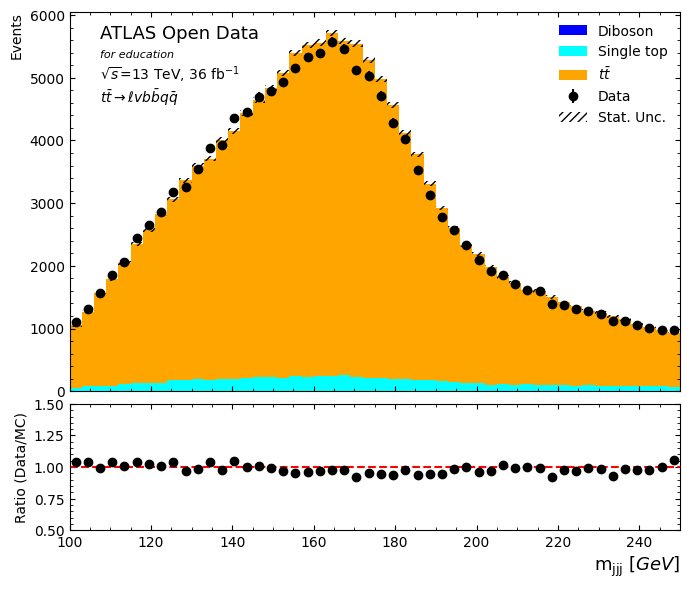

In [19]:
# Plot the trijet mass distribution (m_jjj)
plot_data(data_all,r"$\mathrm{m_{jjj}} \ [GeV]$")

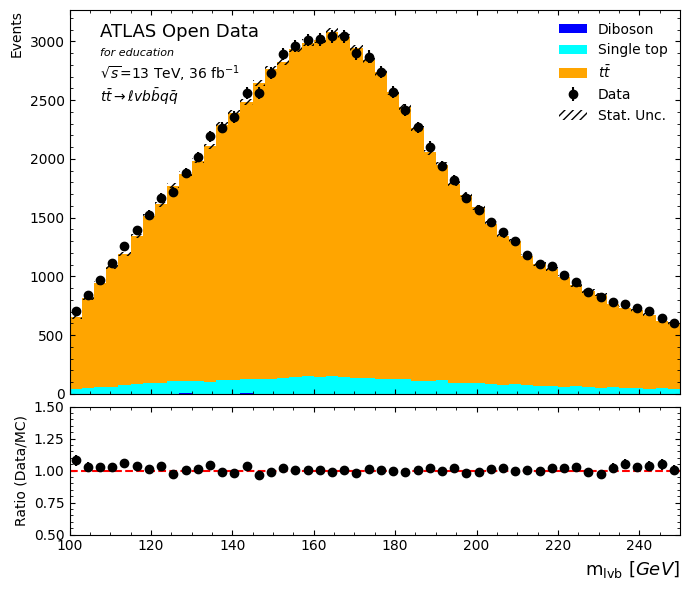

In [20]:
# Plot the lepton-neutrino-b-jet mass distribution (m_lvb)
plot_data(data_all_2,r"$\mathrm{m_{lvb}} \ [GeV]$")